In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [2]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, models, optimizers, losses, metrics, datasets

import matplotlib.pyplot as plt

In [3]:
EPOCHS = 30
BATCH_SIZE = 128
ETA = 1e-3

In [4]:
trainset, testset = datasets.cifar10.load_data()

In [5]:
train_loader = tf.data.Dataset.from_tensor_slices(trainset).batch(BATCH_SIZE).shuffle(1024)
test_loader = tf.data.Dataset.from_tensor_slices(testset).batch(BATCH_SIZE)

## Sparse AutoEncoder

In [6]:
class SparseAutoEncoder(models.Model):
    
    def __init__(self):
        super(SparseAutoEncoder, self).__init__()
        
        self.encoder = models.Sequential([
            layers.Conv2DTranspose(16, (3, 3), strides=(1, 1), padding="SAME", output_padding=0),
            layers.BatchNormalization(),
            layers.Activation(tf.nn.leaky_relu),
            
            layers.Conv2DTranspose(16, (3, 3), strides=(2, 2), padding="SAME", output_padding=1),
            layers.BatchNormalization(),
            layers.Activation(tf.nn.leaky_relu),
            
            layers.Conv2DTranspose(32, (3, 3), strides=(1, 1), padding="SAME", output_padding=0),
            layers.BatchNormalization(),
            layers.Activation(tf.nn.leaky_relu),
            
            layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding="SAME", output_padding=1),
            layers.BatchNormalization(),
            layers.Activation(tf.nn.leaky_relu),
        ])
        
        self.decoder = models.Sequential([
            layers.Conv2D(32, (3, 3), strides=(2, 2), padding="SAME"),
            layers.BatchNormalization(),
            layers.Activation(tf.nn.leaky_relu),
            
            layers.Conv2D(16, (3, 3), strides=(1, 1), padding="SAME"),
            layers.BatchNormalization(),
            layers.Activation(tf.nn.leaky_relu),
            
            layers.Conv2D(16, (3, 3), strides=(2, 2), padding="SAME"),
            layers.BatchNormalization(),
            layers.Activation(tf.nn.leaky_relu),
            
            layers.Conv2D(3, (3, 3), strides=(1, 1), padding="SAME"),
            layers.BatchNormalization(),
            layers.Activation(tf.nn.leaky_relu),
        ])
        
    def call(self, x, training=False):
        latent = self.encoder(x, training=training)
        x_rec = self.decoder(latent, training=training)
        
        return x_rec, latent

In [7]:
def compute_sae_loss(x_orig, x_rec, latent):
    reconstruction_loss = tf.reduce_mean(tf.math.abs(x_orig - x_rec))
    sparse_loss = tf.reduce_mean(latent**2)
    
    loss = reconstruction_loss + 0.1*sparse_loss
    
    return loss

In [8]:
def plot(original, reconstructed):
    plt.figure(figsize=(4, 2))
    
    img1 = original.numpy()*256
    img1 = img1.astype(np.uint8)
    
    img2 = reconstructed.numpy()*256
    img2 = img2.astype(np.uint8)
    
    plt.subplot(1, 2, 1)
    plt.imshow(img1)
    plt.title("Original")
    
    plt.subplot(1, 2, 2)
    plt.imshow(img2)
    plt.title("Reconstructed")
    
    plt.show()

In [9]:
def train():
    model = SparseAutoEncoder()
    optimizer = optimizers.Adam(learning_rate=ETA)
    
    train_loss_metric = metrics.Mean()
    test_loss_metric = metrics.Mean()
    
    for e in range(EPOCHS):
        
        for x, y in train_loader:
            with tf.GradientTape() as tape:
                x = tf.cast(x, dtype=tf.float32)/256
                x_rec, latent = model(x, training=True)
                loss = compute_sae_loss(x, x_rec, latent)
                
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            
            train_loss_metric.update_state(loss)
            
        for x, y in test_loader:
            x = tf.cast(x, dtype=tf.float32)/256
            x_rec, latent = model(x, training=False)
            loss = compute_sae_loss(x, x_rec, latent)
            
            test_loss_metric.update_state(loss)
            
        if (e+1)%3 == 0:
            print(f"Epochs {e+1}/{EPOCHS}, train loss: {train_loss_metric.result():.6f}, test loss: {test_loss_metric.result():.6f}")
            index = np.random.randint(tf.shape(x)[0])
            plot(x[index], x_rec[index])
        
        train_loss_metric.reset_states()
        test_loss_metric.reset_states()

Epochs 3/30, train loss: 0.043727, test loss: 0.062000


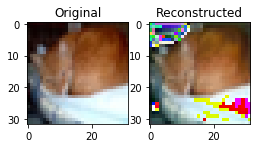

Epochs 6/30, train loss: 0.030198, test loss: 0.022387


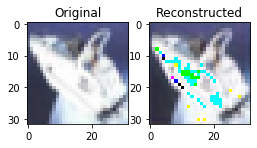

Epochs 9/30, train loss: 0.023010, test loss: 0.036401


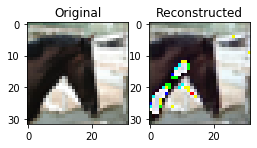

Epochs 12/30, train loss: 0.018155, test loss: 0.013842


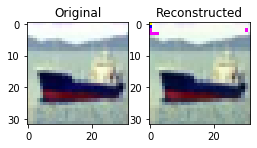

Epochs 15/30, train loss: 0.014066, test loss: 0.015445


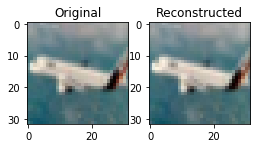

Epochs 18/30, train loss: 0.013451, test loss: 0.022168


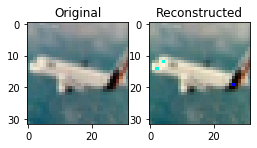

Epochs 21/30, train loss: 0.013095, test loss: 0.013457


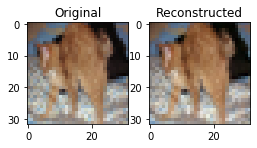

Epochs 24/30, train loss: 0.012502, test loss: 0.009205


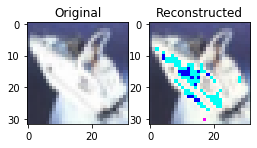

Epochs 27/30, train loss: 0.012551, test loss: 0.006486


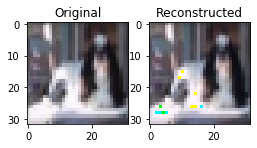

Epochs 30/30, train loss: 0.012366, test loss: 0.009248


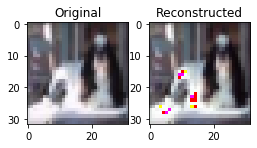

In [10]:
train()

## Denoising AutoEncoder

In [11]:
class AutoEncoder(models.Model):
    """
    오토인코더
    """
    
    def __init__(self):
        super(AutoEncoder, self).__init__()
        
        self.encoder = models.Sequential([
            layers.Conv2D(32, (3, 3), strides=(1, 1), padding="SAME"),
            layers.BatchNormalization(),
            layers.Activation(tf.nn.relu),
            
            layers.Conv2D(32, (3, 3), strides=(2, 2), padding="SAME"),
            layers.BatchNormalization(),
            layers.Activation(tf.nn.relu),
            
            layers.Conv2D(32, (3, 3), strides=(2, 2), padding="SAME"),
            layers.BatchNormalization(),
            layers.Activation(tf.nn.relu),
        ])
        
        self.decoder = models.Sequential([
            layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding="SAME", output_padding=1),
            layers.BatchNormalization(),
            layers.Activation(tf.nn.relu),
            
            layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding="SAME", output_padding=1),
            layers.BatchNormalization(),
            layers.Activation(tf.nn.relu),
            
            layers.Conv2DTranspose(3, (3, 3), strides=(1, 1), padding="SAME", output_padding=0),
            layers.BatchNormalization(),
            layers.Activation(tf.nn.sigmoid),
        ])
        
    def call(self, x, training=False):
        latent = self.encoder(x, training=training)
        x_rec = self.decoder(latent, training=training)
        
        return x_rec

In [12]:
def add_noise(x):
    x_with_noise = x + tf.random.normal(tf.shape(x))*0.01
    return x_with_noise

In [13]:
def compute_loss(x1, x2):
    reconstruction_loss = tf.reduce_mean(tf.math.abs(x1 - x2))
    return reconstruction_loss

In [14]:
def train():
    model = AutoEncoder()
    optimizer = optimizers.Adam(learning_rate=ETA)
    
    train_loss_metric = metrics.Mean()
    test_loss_metric = metrics.Mean()
    
    for e in range(EPOCHS):
        
        for x, y in train_loader:
            with tf.GradientTape() as tape:
                x = tf.cast(x, dtype=tf.float32)/256
                x_with_noise = add_noise(x)
                x_rec = model(x_with_noise, training=True)
                loss = compute_loss(x, x_rec)
                
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            
            train_loss_metric.update_state(loss)
            
        for x, y in test_loader:
            x = tf.cast(x, dtype=tf.float32)/256
            x_rec = model(x, training=False)
            loss = compute_loss(x, x_rec)
            
            test_loss_metric.update_state(loss)
            
        print(f"Epochs {e+1}/{EPOCHS}, train loss: {train_loss_metric.result():.6f}, test loss: {test_loss_metric.result():.6f}")
        index = np.random.randint(tf.shape(x)[0])
        plot(x[index], x_rec[index])
        
        train_loss_metric.reset_states()
        test_loss_metric.reset_states()

Epochs 1/30, train loss: 0.053900, test loss: 0.058716


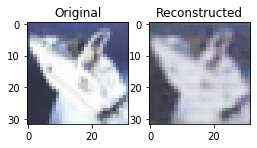

Epochs 2/30, train loss: 0.030963, test loss: 0.034879


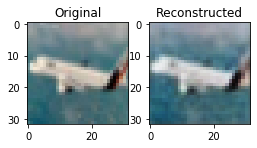

Epochs 3/30, train loss: 0.026992, test loss: 0.032617


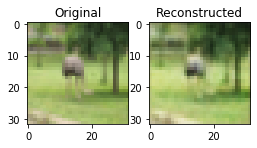

Epochs 4/30, train loss: 0.024769, test loss: 0.024344


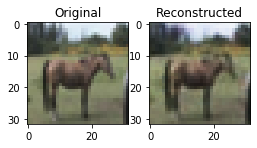

Epochs 5/30, train loss: 0.022907, test loss: 0.021531


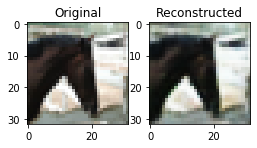

Epochs 6/30, train loss: 0.021828, test loss: 0.041351


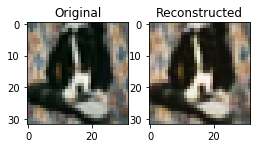

Epochs 7/30, train loss: 0.021091, test loss: 0.022699


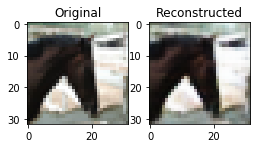

Epochs 8/30, train loss: 0.020263, test loss: 0.017908


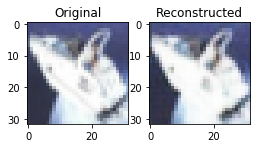

Epochs 9/30, train loss: 0.019707, test loss: 0.017349


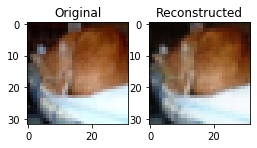

Epochs 10/30, train loss: 0.019176, test loss: 0.019005


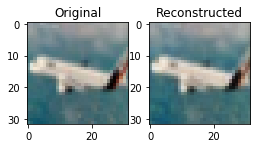

Epochs 11/30, train loss: 0.018718, test loss: 0.015481


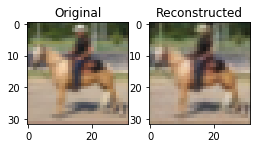

Epochs 12/30, train loss: 0.018505, test loss: 0.015601


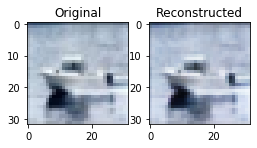

Epochs 13/30, train loss: 0.018036, test loss: 0.017542


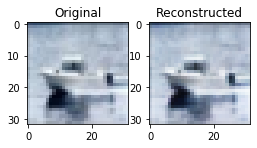

Epochs 14/30, train loss: 0.017734, test loss: 0.017112


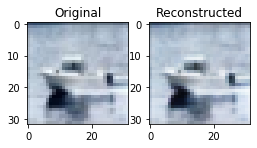

Epochs 15/30, train loss: 0.017698, test loss: 0.013243


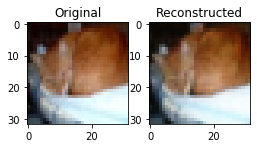

Epochs 16/30, train loss: 0.017311, test loss: 0.014139


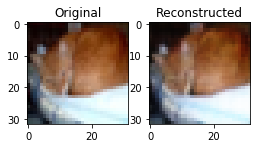

Epochs 17/30, train loss: 0.016958, test loss: 0.013640


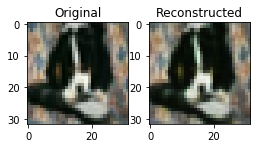

Epochs 18/30, train loss: 0.016957, test loss: 0.015240


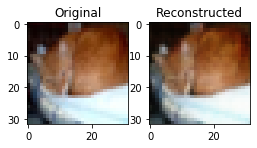

Epochs 19/30, train loss: 0.016537, test loss: 0.016386


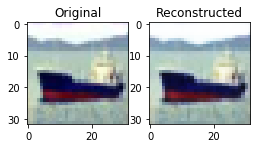

Epochs 20/30, train loss: 0.016369, test loss: 0.012885


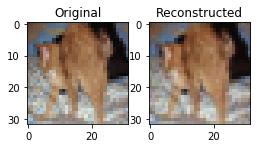

Epochs 21/30, train loss: 0.016295, test loss: 0.011939


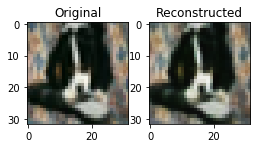

Epochs 22/30, train loss: 0.016055, test loss: 0.017354


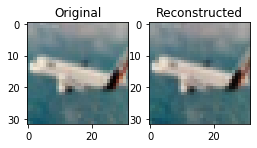

Epochs 23/30, train loss: 0.015938, test loss: 0.013653


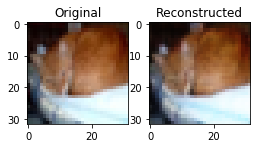

Epochs 24/30, train loss: 0.016012, test loss: 0.012066


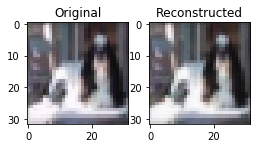

Epochs 25/30, train loss: 0.015916, test loss: 0.015020


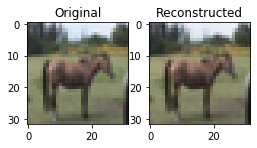

Epochs 26/30, train loss: 0.015734, test loss: 0.013281


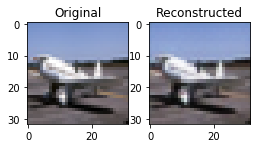

Epochs 27/30, train loss: 0.015643, test loss: 0.012999


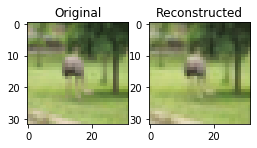

Epochs 28/30, train loss: 0.015440, test loss: 0.012825


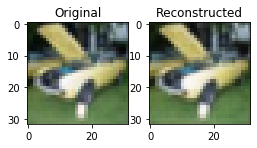

Epochs 29/30, train loss: 0.015178, test loss: 0.011882


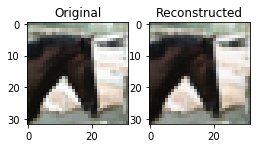

Epochs 30/30, train loss: 0.015368, test loss: 0.011369


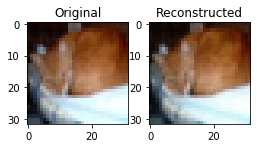

In [15]:
train()